![PPGI_UFRJ](https://github.com/zavaleta/Fundamentos_DS/blob/main/imagens/ppgi-ufrj.png?raw=1)
# Fundamentos de Ciência de Dados
## 2022 - BL2
### **Aluno:** Gilberto Gil, Saulo Andrade Almeida, Valquire

# Trabalho Final
---

In [1]:
#checking version machine architecture, OS, python and all libs used in this notebook
import platform as platform
import numpy as np
import pandas as pd
import os
import conda

def checkingEnvironmentVersions(details=False):

    #definnig version of python and all libs used
    HOST_MACHINE_ARCHTECTURE_EXPECTED = 'x86_64'
    HOST_MACHINE_OS_EXPECTED = 'Linux'
    HOST_MACHINE_PLATFORM = 'Linux-5.15.0-47-generic-x86_64-with-glibc2.31'
    CONDA_VERSION_EXPECTED = '4.14.0'
    CONDA_DEFAULT_ENV_EXPECTED = 'drecvmenv'
    PYTHON_VERSION_EXPECTED = '3.9.12'
    NUMPY_LIB_VERSION_EXPECTED = '1.21.5'
    PANDAS_LIB_VERSION_EXPECTED = '1.4.2'
    

    if details: 
        print('Host Machine Architecture:', platform.machine())
        print('Host Machine OS:', platform.system())
        print('Conda Version:', conda.__version__)
        print('Conda default env:', os.environ['CONDA_DEFAULT_ENV'])
        print('Python Version:', platform.python_version())
        print('NumPy Lib Version:', np.__version__)
        print('Pandas Lib Version:', pd.__version__)
        
    #checking versions
    try:
        #checking Machine Architecute expected
        assert platform.machine() == HOST_MACHINE_ARCHTECTURE_EXPECTED

        #checking OS expected
        assert platform.system() == HOST_MACHINE_OS_EXPECTED
        
        #checking conda version
        assert conda.__version__ == CONDA_VERSION_EXPECTED
        
        #checking conda default environment
        assert os.environ['CONDA_DEFAULT_ENV'] == CONDA_DEFAULT_ENV_EXPECTED    

        #checking python version
        assert platform.python_version() == PYTHON_VERSION_EXPECTED

        #checking numpy lib version
        assert np.__version__ == NUMPY_LIB_VERSION_EXPECTED  

        #checking Pandas lib version
        assert pd.__version__ == PANDAS_LIB_VERSION_EXPECTED         
    except:
        #if any assert fail, or something else get wrong during verification
        if details: print('Something is wrong!')
        return False
    else:
        #if pass all asserts
        if details: print('All versions are correct!')
        return True

In [2]:
def executingExperiment():
    print("Executando o experimento")

In [19]:
import sys, subprocess, datetime
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image

def createProvenance(agent, entity, activity, graph):
    # Creating an empty provenance document
    d1 = ProvDocument()

    # Declaring namespaces for various prefixes used in the excution of Randon Walk Experiment
    d1.add_namespace('ufrj', 'http://www.ufrj.br/ppgi/')
    d1.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')

    # Adding an entity
    entity = "ufrj:"+ entity
    e1 = d1.entity(entity)

    # Adding an Agent 
    agent = "foaf:"+ agent
    d1.agent(agent)

    # Attributing the execution of the experiment to the PROV-Agent
    d1.wasAttributedTo(e1, agent)

    # Adding an activity
    activity = "ufrj:"+ activity
    d1.activity(activity)

    # Generation
    d1.wasGeneratedBy( entity, activity)

    # Adding a role to the PROV-Agent and timestamp to dataset
    d1.agent(agent, {'prov:hadRole': 'Executor', 'foaf:mbox': 'sauloandrade@gmail.com', 'prov:attributedAtTime': str(datetime.datetime.utcnow())})
    d1.entity(entity, {'prov:generatedAtTime': str(datetime.datetime.utcnow())})

    ### END - Registering Retrospective Provenance 

    ### Optional outputs ####

    #Generating the outup - a  Provenance Graph
    dot = prov_to_dot(d1)
    graph = graph +".png"
    dot.write_png(graph)

    #Generating the Serialization - Output XML
    d1.serialize(entity + ".xml", format='xml') 

    #Generating the Serialization - Output Turtle
    d1.serialize(entity + ".ttl", format='rdf', rdf_format='ttl')

Host Machine Architecture: x86_64
Host Machine OS: Linux
Conda Version: 4.14.0
Conda default env: drecvmenv
Python Version: 3.9.12
NumPy Lib Version: 1.21.5
Pandas Lib Version: 1.4.2
All versions are correct!
Executando o experimento


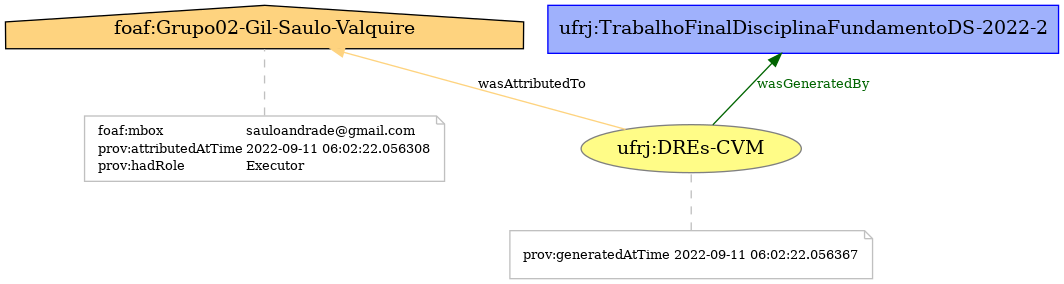

In [21]:
agent    = "Grupo02-Gil-Saulo-Valquire"                                         #PROV-Agent
entity   = "DREs-CVM"                                                           #PROV-Entity
activity = "TrabalhoFinalDisciplinaFundamentoDS-2022-2"                         #PROV-Activity
graph = entity                                                                  #PROV-Graph

def main():
    if(checkingEnvironmentVersions(True)):
        executingExperiment()
        createProvenance(agent, entity, activity, graph)
        
main()
Image(graph+".png")